In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Traitement General

In [ ]:
import pandas as pd
import requests
import re
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# Afficher toutes les lignes et colonnes
pd.set_option('display.max_columns', None)

In [ ]:
# Charger le fichier des commandes de vir depuis 2022
commandes = pd.read_excel(commandes_vir_22_path)
print('commandes vir depuis 2022  shape:', commandes.shape)

commandes vir depuis 2022  shape: (219530, 12)


In [ ]:
#Charger les path
facture_principale_path = '/content/drive/Shareddrives/Supply chain/BU Logistique/27. Factures/VIR/Benelux/2024/Septembre 2024/FACTURATION BOBOCHIC SEPTEMBRE 2024 (1).xlsx'
facture_complementaire_path = '/content/drive/Shareddrives/Supply chain/BU Logistique/27. Factures/VIR/Benelux/2024/Septembre 2024/FACTURE COMPL BOBOCHIC SEPTEMBRE 2024 (1).xlsx'
commandes_vir_22_path = "/content/drive/Shareddrives/Supply chain/BU Logistique/27. Factures/VIR/Commandes VIR depuis 2022/commandes_vir_2022.xlsx"

In [ ]:
# Define file paths for monthly and annual files
monthly_file_path = '/content/drive/Shareddrives/Supply chain/BU Logistique/27. Factures/VIR/Benelux/2024/Septembre 2024/facture_septembre_24.xlsx'
annual_file_path = '/content/drive/Shareddrives/Supply chain/BU Logistique/27. Factures/VIR/Benelux/2024/annual_data_benelux.xlsx'


In [ ]:
# Charger les données du fichier principal (onglet CUMUL)
facture_principale = pd.read_excel(facture_principale_path, sheet_name='CUMUL')
print('facture_principale shape:', facture_principale.shape)
# Charger le fichier facture complémentaire
facture_complementaire = pd.read_excel(facture_complementaire_path, sheet_name='CUMUL')
print('facture_complementaire  shape:', facture_complementaire.shape)

facture_principale shape: (4230, 41)
facture_complementaire  shape: (390, 22)


In [ ]:
# Nettoyage des références de commande : conserver uniquement les 9 premières lettres
def nettoyer_reference(ref):
    return re.sub(r'[^A-Za-z]', '', str(ref))[:9]

facture_principale['Reference'] = facture_principale['Reference'].apply(nettoyer_reference)
facture_complementaire['Référence'] = facture_complementaire['Référence'].apply(nettoyer_reference)

In [ ]:
# Renommer 'Référence' en 'Reference' et 'Dpt' en 'C.Postal' dans facture_complementaire
facture_complementaire = facture_complementaire.rename(columns={'Référence': 'Reference', 'Dpt': 'C.Postal', 'Rubrique': 'Rub'})
facture_principale = facture_principale.rename(columns={'Kg': 'Poids'})
commandes = commandes.rename(columns={'REFERENCE': 'Reference'})

In [ ]:
# Garder seulement les 2 premiers chiffres dans la colonne 'C.Postal' pour les deux DataFrames
facture_principale['C.Postal'] = facture_principale['C.Postal'].astype(str).str[:2]
facture_complementaire['C.Postal'] = facture_complementaire['C.Postal'].astype(str).str[:2]

In [ ]:
# Filtre pour le libellé commençant par 'LIV' ou contenant 'Emporté dépôt'
filtre_libelle = facture_principale['Libelle'].str.startswith('LIV') | (facture_principale['Libelle'] == 'EMPORTE DEPOT')

In [ ]:
liste_references_commandes = commandes['Reference'].unique().tolist()
len(liste_references_commandes)

192518

In [ ]:
commandes_unique = commandes.drop_duplicates(subset=['Reference'])

In [ ]:
# Effectuer le merge
facture_principale_merged = pd.merge(
    facture_principale,
    commandes_unique,
    on='Reference',
    how='left'
)

In [ ]:
# Effectuer le merge
facture_complementaire_merged = pd.merge(
    facture_complementaire,
    commandes_unique,
    on='Reference',
    how='left'
)

In [ ]:
liste_references_facture_principale = facture_principale['Reference'].unique().tolist()
len(liste_references_facture_principale)


3765

In [ ]:
print('commandes:', commandes.shape)
print("*******************************")
print('facture_principale avant le merge:', facture_principale.shape)
print('facture_principale apres le merge:', facture_principale_merged.shape)
print("*******************************")
print('facture_complementaire avant le merge:', facture_complementaire.shape)
print('facture_complementaire apres le merge:', facture_complementaire_merged.shape)

commandes: (219530, 12)
*******************************
facture_principale avant le merge: (4230, 41)
facture_principale apres le merge: (4230, 52)
*******************************
facture_complementaire avant le merge: (390, 22)
facture_complementaire apres le merge: (390, 33)


In [ ]:
# Création du dictionnaire de correspondance entre Rub et Libelle depuis facture_principal
rub_libelle_dict = dict(zip(facture_principale['Rub'], facture_principale['Libelle']))
len(rub_libelle_dict)


19

In [ ]:
rub_libelle_dict

{'ENL': 'ENLEVEMENT DEPOT',
 'FA': 'FRAIS ADMINISTRATIFS',
 'PA4': 'PASSAGE A 4',
 'LS': 'LIV STANDARD',
 'MTA': 'MONTAGE CLASSE A',
 'LI': 'LIV INSTALLATION',
 'LC': 'LIV ECONOMIQUE',
 'ED': 'EMPORTE DEPOT',
 'RPC': 'REPRISE POUR DESTRUCTION CANAPE',
 'STO': 'STOCKAGE',
 'LM': 'LIV MONTAGE',
 'MTB': 'MONTAGE CLASSE B',
 'RPM': 'REPRISE POUR DESTRUCTION MEUBLE',
 'RPE': 'REPRISE ELECTRO DEEE',
 'RPL': 'REPRISE POUR DESTRUCTION LITERIE',
 'LD': 'LIV DEBALLAGE',
 'RET': 'RETOUR REVERSE',
 'MTC': 'MONTAGE CLASSE C',
 'PA': 'PASSAGE A 4'}

# Factures principales

In [ ]:
facture_principale_merged.head(3)

,Code,Nom,DO/EN,DO,Ens.,Enseigne,Commande,Reference,Reference2,Destinataire,C.Postal,Ville,Mode RDV,Saisie,Réception,Premier appel,Délai phoning,Prise RDV,Première date dispo,Meilleur délai proposé,Livraison,Délai Liv,Point,Date,Rub,Libelle,Qte,UN,PU,DISTRIBUTION,APPROCHE,GASOIL DISTRI,GASOIL APP,Ag,Liv,Dir,Vol,Poids,Prd,Trafic,saisie,ID_PRODUIT,CATEGORY,DESIGNATION,CA_presta,QTY,TRANSPORT_ACHAT,POIDS,NB_COLIS,TRANSPORTEUR,SUPPLIER,mode de paiement
0,70907,NEGOMARKETS,DO,70907,70907,NEGOMARKETS,1000,TOURNEEGB,NaN,TOURNEE DEDIEE BOBOCHIC,77,EMERAINVILLE,EDI,2024-09-16,NaT,NaT,NaN,NaT,NaN,NaN,2024-09-17,0.0,LIVCFM,2024-09-18,ENL,ENLEVEMENT DEPOT,1.0,UN,0.0,850.0,NaN,18.7,0.0,96,96,TBO1,NaN,NaN,NaN,ENL,SAISIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70907,NEGOMARKETS,DO,70907,70907,NEGOMARKETS,1000,TOURNEEGB,NaN,TOURNEE DEDIEE BOBOCHIC,77,EMERAINVILLE,EDI,2024-09-16,NaT,NaT,NaN,NaT,NaN,NaN,2024-09-18,1.0,LIVCFM,2024-09-19,ENL,ENLEVEMENT DEPOT,1.0,UN,0.0,850.0,NaN,18.7,0.0,96,96,TBO1,NaN,NaN,NaN,ENL,SAISIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70907,NEGOMARKETS,DO,70907,70907,NEGOMARKETS,1000,TOURNEEGB,NaN,TOURNEE DEDIEE BOBOCHIC,77,EMERAINVILLE,EDI,2024-09-17,NaT,NaT,NaN,NaT,NaN,NaN,2024-09-19,1.0,LIVCFM,2024-09-19,ENL,ENLEVEMENT DEPOT,1.0,UN,0.0,850.0,NaN,18.7,0.0,96,96,TBO1,NaN,NaN,NaN,ENL,SAISIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
colonnes_a_supprimer = ['Prd',  'Qte', 'UN',  'Destinataire', 'Enseigne',
                        'Reference2','Première date dispo','Ag','Nom','Délai Liv',
                        'Meilleur délai proposé','DO', "Ens.",'Mode RDV','Point',
                        'Premier appel','Saisie', 'Réception',  'Délai phoning',
                        'Prise RDV','Date','DO/EN','Trafic' ,'Date']
facture_principale_merged = facture_principale_merged.drop(columns=colonnes_a_supprimer)

In [ ]:
facture_principale_merged.shape

(4230, 29)

In [ ]:
# Renommer la colonne 'Unnamed: 33' en 'Total'
facture_principale_merged = facture_principale_merged.rename(columns={'Unnamed: 34': 'Total', 'Liv': 'Agence', 'Commande':"commande_VIR", "PU" : "CA", "Livraison" : "Date", 'Vol': 'Volume'})

# Calculer la somme des colonnes spécifiées pour chaque ligne et l'attribuer à la colonne 'Total'
facture_principale_merged['Total'] = facture_principale_merged[[ 'DISTRIBUTION', 'APPROCHE', 'GASOIL DISTRI',
       'GASOIL APP']].sum(axis=1)
# Arrondir la colonne 'Total' à 2 décimales
facture_principale_merged['Total'] = facture_principale_merged['Total'].round(2)

In [ ]:
#Étape 1 : Convertir la colonne 'Date' en format datetime
facture_principale_merged['Date'] = pd.to_datetime(facture_principale_merged['Date'], errors='coerce')

# Étape 2 : Extraire le mois de la colonne 'Date'
facture_principale_merged['Mois'] = facture_principale_merged['Date'].dt.month
# Vérification des résultats
print(facture_principale_merged[['Date', 'Mois']].head())

        Date  Mois
0 2024-09-17   9.0
1 2024-09-18   9.0
2 2024-09-19   9.0
3 2024-09-20   9.0
4 2024-09-21   9.0


In [ ]:
facture_principale_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Code              4230 non-null   int64         
 1   commande_VIR      4230 non-null   int64         
 2   Reference         4230 non-null   object        
 3   C.Postal          4230 non-null   object        
 4   Ville             4107 non-null   object        
 5   Date              4106 non-null   datetime64[ns]
 6   Rub               4230 non-null   object        
 7   Libelle           4230 non-null   object        
 8   CA                4106 non-null   float64       
 9   DISTRIBUTION      4112 non-null   float64       
 10  APPROCHE          3582 non-null   float64       
 11  GASOIL DISTRI     4059 non-null   float64       
 12  GASOIL APP        4059 non-null   float64       
 13  Agence            4230 non-null   int64         
 14  Dir               4133 n

In [ ]:
facture_principale_merged['Libelle'].value_counts()

,count
Libelle,
LIV STANDARD,2380
LIV INSTALLATION,1118
REPRISE POUR DESTRUCTION CANAPE,294
LIV ECONOMIQUE,207
FRAIS ADMINISTRATIFS,107
LIV MONTAGE,28
MONTAGE CLASSE B,22
PASSAGE A 4,20
EMPORTE DEPOT,13


In [ ]:
# Séparer les lignes correspondant et ne correspondant pas aux critères
facture_principale_merged_liv = facture_principale_merged[filtre_libelle]

In [ ]:
#shape apres retrait des livraison complementaires
print("shape apres retrait des livraisons complementaires:", facture_principale_merged_liv.shape)

shape apres retrait des livraisons complementaires: (3747, 31)


In [ ]:
liste_references_facture_principale_merged_liv = facture_principale_merged_liv['Reference'].unique().tolist()
len( liste_references_facture_principale_merged_liv)

3742

In [ ]:
facture_principale_merged_liv['Libelle'].value_counts()

,count
Libelle,
LIV STANDARD,2380
LIV INSTALLATION,1118
LIV ECONOMIQUE,207
LIV MONTAGE,28
EMPORTE DEPOT,13
LIV DEBALLAGE,1


Text(0.5, 1.0, 'Distribution selon type de la prestation')

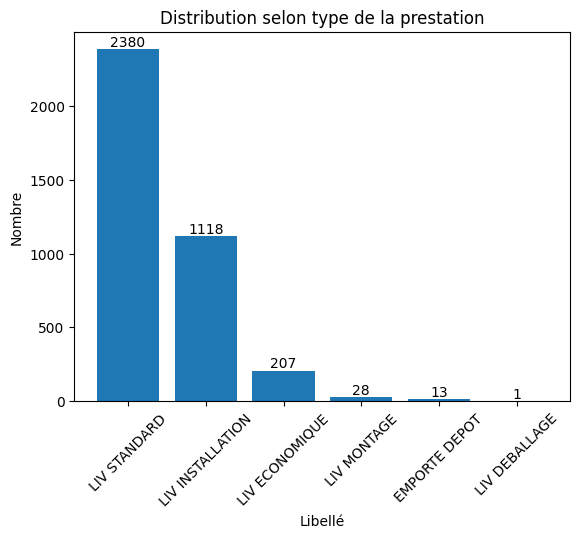

In [ ]:
plt.bar(facture_principale_merged_liv['Libelle'].value_counts().index, facture_principale_merged_liv['Libelle'].value_counts().values)
plt.xticks(rotation=45)
values = facture_principale_merged_liv['Libelle'].value_counts().values

# Ajouter les valeurs au-dessus des barres
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

# Ajouter les labels des axes
plt.xlabel('Libellé')
plt.ylabel('Nombre')
plt.title('Distribution selon type de la prestation')

In [ ]:
facture_principale_merged_liv['Libelle'].count()

3747

In [ ]:
facture_principale_merged_liv.columns

Index(['Code', 'commande_VIR', 'Reference', 'C.Postal', 'Ville', 'Date', 'Rub',
       'Libelle', 'CA', 'DISTRIBUTION', 'APPROCHE', 'GASOIL DISTRI',
       'GASOIL APP', 'Agence', 'Dir', 'Volume', 'Poids', 'saisie',
       'ID_PRODUIT', 'CATEGORY', 'DESIGNATION', 'CA_presta', 'QTY',
       'TRANSPORT_ACHAT', 'POIDS', 'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER',
       'mode de paiement', 'Total', 'Mois'],
      dtype='object')

In [ ]:
facture_principale_merged_liv.head(3)

,Code,commande_VIR,Reference,C.Postal,Ville,Date,Rub,Libelle,CA,DISTRIBUTION,APPROCHE,GASOIL DISTRI,GASOIL APP,Agence,Dir,Volume,Poids,saisie,ID_PRODUIT,CATEGORY,DESIGNATION,CA_presta,QTY,TRANSPORT_ACHAT,POIDS,NB_COLIS,TRANSPORTEUR,SUPPLIER,mode de paiement,Total,Mois
12,70907,440067081,SXFNLNCQI,44,ST NAZAIRE,2024-09-06,LS,LIV STANDARD,0.0,84.38,57.876,1.85636,1.273272,44,T10,0.000,182.0,SAISIE,17116.0,Canapé d'angle fixe,Canapé d'angle fixe EVEREST tissu chiné avec p...,2148.34,1.0,300.7800,334.0,3.0,virtransport_li,BLUE SUN,YounitedPay,145.39,9.0
14,70907,961234424,PLJTVSYMW,95,AUVERS SUR OISE,2024-09-07,LI,LIV INSTALLATION,0.0,89.30,NaN,1.96460,0.000000,96,T15,1.753,94.0,SAISIE,17364.0,Canapé droit fixe,Canapé droit fixe 3 places LEOPOLD tissu chiné...,0.00,1.0,123.3784,94.0,2.0,virtransport_li,BLUE SUN,Commande Gagnant Concours,91.26,9.0
16,70907,961264696,BWZUIZWJL,77,CHOISY EN BRIE,2024-09-02,LS,LIV STANDARD,0.0,79.35,NaN,1.74570,0.000000,96,T24,3.437,145.0,EDI,16987.0,Canapé d'angle,Canapé d'angle fixe modulable ROUSSEAU tissu c...,0.00,1.0,143.6200,145.0,4.0,virtransport_ls,BLUE SUN,Commande partielle,81.10,9.0


In [ ]:
colonnes_ordre = ['Mois', 'Code', 'Date', 'commande_VIR','Rub', 'Libelle',
                  'Reference', 'C.Postal', 'Ville',  'CA', 'DISTRIBUTION',
       'APPROCHE', 'GASOIL DISTRI', 'GASOIL APP', 'Total', 'Agence', 'Dir',
       'Volume', 'Poids',   'ID_PRODUIT', 'CATEGORY',
       'DESIGNATION', 'CA_presta', 'QTY', 'TRANSPORT_ACHAT', 'POIDS',
       'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER', 'mode de paiement'
]
facture_principale_merged_liv = facture_principale_merged_liv[colonnes_ordre]

In [ ]:
facture_principale_merged_liv.head(3)

,Mois,Code,Date,commande_VIR,Rub,Libelle,Reference,C.Postal,Ville,CA,DISTRIBUTION,APPROCHE,GASOIL DISTRI,GASOIL APP,Total,Agence,Dir,Volume,Poids,ID_PRODUIT,CATEGORY,DESIGNATION,CA_presta,QTY,TRANSPORT_ACHAT,POIDS,NB_COLIS,TRANSPORTEUR,SUPPLIER,mode de paiement
12,9.0,70907,2024-09-06,440067081,LS,LIV STANDARD,SXFNLNCQI,44,ST NAZAIRE,0.0,84.38,57.876,1.85636,1.273272,145.39,44,T10,0.000,182.0,17116.0,Canapé d'angle fixe,Canapé d'angle fixe EVEREST tissu chiné avec p...,2148.34,1.0,300.7800,334.0,3.0,virtransport_li,BLUE SUN,YounitedPay
14,9.0,70907,2024-09-07,961234424,LI,LIV INSTALLATION,PLJTVSYMW,95,AUVERS SUR OISE,0.0,89.30,NaN,1.96460,0.000000,91.26,96,T15,1.753,94.0,17364.0,Canapé droit fixe,Canapé droit fixe 3 places LEOPOLD tissu chiné...,0.00,1.0,123.3784,94.0,2.0,virtransport_li,BLUE SUN,Commande Gagnant Concours
16,9.0,70907,2024-09-02,961264696,LS,LIV STANDARD,BWZUIZWJL,77,CHOISY EN BRIE,0.0,79.35,NaN,1.74570,0.000000,81.10,96,T24,3.437,145.0,16987.0,Canapé d'angle,Canapé d'angle fixe modulable ROUSSEAU tissu c...,0.00,1.0,143.6200,145.0,4.0,virtransport_ls,BLUE SUN,Commande partielle


In [ ]:
# Step 1: Create or update the monthly file with Principal sheet
if os.path.exists(monthly_file_path):
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='a') as writer:
        # Append monthly data to 'Principal' sheet
        facture_principale_merged_liv.to_excel(writer, sheet_name='Principal', index=False)
else:
    # Create the file and add the Principal sheet with the data
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='w') as writer:
        facture_principale_merged_liv.to_excel(writer, sheet_name='Principal', index=False)

print("Monthly data for Principal has been saved.")


Monthly data for Principal has been saved.


In [ ]:
# Step 1: Check if the annual file exists
if not os.path.exists(annual_file_path):
    # Create a new Excel file with the 'Principal' sheet
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='w') as writer:
        facture_principale_merged_liv.to_excel(writer, sheet_name='Principal', index=False)
    print(f"Annual file created at: {annual_file_path}")

else:
    # If the file exists, read the existing data from the 'Principal' sheet
    try:
        existing_annual_data = pd.read_excel(annual_file_path, sheet_name='Principal')
        # Concatenate the existing data with the new data
        updated_annual_data = pd.concat([existing_annual_data, facture_principale_merged_liv], ignore_index=True)

    except ValueError as e:
        # Handle case where the 'Principal' sheet does not exist
        if 'Worksheet named' in str(e):
            print("Worksheet 'Principal' not found. Creating a new one.")
            updated_annual_data = facture_principale_merged_liv
        else:
            raise  # Raise any other exceptions

    # Save the updated data back to the annual file
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        updated_annual_data.to_excel(writer, sheet_name='Principal', index=False)

    print("Annual data for Principal has been updated.")

Annual data for Principal has been updated.


# Factures complementaires


1.   Fichier facture complementaire envoyé par VIR
2.   Filtre sur les mouvements considérés complementaires mais dans le fichier facture principale



## Facture complémentaire envoyée par VIR


In [ ]:
facture_complementaire_merged.head(2)

,Ag,Date,Code,Commentaires,Cde,Reference,Réf.2,Payeur,Enseigne,Destinataire,Adresse,C.Postal,Ville,ColAno,Rub,Poids,CA,APP ALLER,APP RETOUR,GASOIL CA,GASOIL APP ALLER,GASOIL APP RETOUR,ID_PRODUIT,CATEGORY,DESIGNATION,CA_presta,QTY,TRANSPORT_ACHAT,POIDS,NB_COLIS,TRANSPORTEUR,SUPPLIER,mode de paiement
0,96.0,2024-09-07 08:45:29,ANNULE AVANT LIV,574144 ( Manuelle ),961266905.0,KVRKHTSUO,NaN,70907.0,70907.0,VIR BY JP 96 CELTON HUGO,6 BOULEVARD OLOF PALME,77,EMERAINVILLE,0.0,ED,28.0,NaN,NaN,18.312,0.00000,0.0,0.402864,16317.0,Fauteuil & pouf,Pouf ARSENE - Couleur : Gris clair,0.0,1.0,24.4100,28.0,1.0,virtransport_ed,BLUE SUN,Commande partielle
1,96.0,2024-09-22 09:56:19,CLIENT ABS,NON LIVRE CAR CLIENT ABSENT,996917326.0,DXZAGRZVH,NaN,70907.0,70907.0,NZIE YVANA,24 RUE TLEMCEN,75,PARIS,0.0,RPC,1.0,39.32,NaN,NaN,0.86504,0.0,0.000000,10205.0,Canapé d'angle convertible,Canapé d'angle L convertible SWEDEN - Couleur ...,0.0,1.0,113.3939,111.0,2.0,virtransport_ls_r,BLUE SUN,B2B_SHOWROOMPRIVE_06_129932


In [ ]:
facture_complementaire_merged.columns

Index(['Ag', 'Date', 'Code', 'Commentaires', 'Cde', 'Reference', 'Réf.2',
       'Payeur', 'Enseigne', 'Destinataire', 'Adresse', 'C.Postal', 'Ville',
       'ColAno', 'Rub', 'Poids', 'CA', 'APP ALLER', 'APP RETOUR', 'GASOIL CA',
       'GASOIL APP ALLER', 'GASOIL APP RETOUR', 'ID_PRODUIT', 'CATEGORY',
       'DESIGNATION', 'CA_presta', 'QTY', 'TRANSPORT_ACHAT', 'POIDS',
       'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER', 'mode de paiement'],
      dtype='object')

In [ ]:
#Étape 1 : Convertir la colonne 'Date' en format datetime
facture_complementaire_merged['Date'] = pd.to_datetime(facture_complementaire_merged['Date'], errors='coerce')

# Étape 2 : Extraire le mois de la colonne 'Date'
facture_complementaire_merged['Mois'] = facture_complementaire_merged['Date'].dt.month
# Vérification des résultats
print(facture_complementaire_merged[['Date', 'Mois']].head())

                 Date  Mois
0 2024-09-07 08:45:29   9.0
1 2024-09-22 09:56:19   9.0
2 2024-09-30 11:05:19   9.0
3 2024-09-24 09:39:17   9.0
4 2024-09-17 09:31:24   9.0


In [ ]:
facture_complementaire_merged.fillna(0, inplace=True)

In [ ]:
facture_complementaire_merged.columns

Index(['Ag', 'Date', 'Code', 'Commentaires', 'Cde', 'Reference', 'Réf.2',
       'Payeur', 'Enseigne', 'Destinataire', 'Adresse', 'C.Postal', 'Ville',
       'ColAno', 'Rub', 'Poids', 'CA', 'APP ALLER', 'APP RETOUR', 'GASOIL CA',
       'GASOIL APP ALLER', 'GASOIL APP RETOUR', 'ID_PRODUIT', 'CATEGORY',
       'DESIGNATION', 'CA_presta', 'QTY', 'TRANSPORT_ACHAT', 'POIDS',
       'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER', 'mode de paiement', 'Mois'],
      dtype='object')

In [ ]:
facture_complementaire_merged.rename(columns={'Ag': 'Agence', 'Code': 'Commentaire', 'Cde': 'commande_VIR', "Payeur": 'Code', 'APP RETOUR ':'APP RETOUR','GASOIL  CA':'GASOIL CA'}, inplace = "True" )

In [ ]:
facture_complementaire_merged['Total'] = (
    facture_complementaire_merged['CA'] +
    facture_complementaire_merged['APP ALLER'] +
    facture_complementaire_merged['APP RETOUR'] +
    facture_complementaire_merged['GASOIL CA'] +
    facture_complementaire_merged['GASOIL APP ALLER'] +
    facture_complementaire_merged['GASOIL APP RETOUR']
).round(2)

In [ ]:
colonne_a_supprimer = ["Réf.2", "Destinataire","Enseigne", "Adresse", "ColAno", 'Commentaires']
facture_complementaire_merged = facture_complementaire_merged.drop(columns=colonne_a_supprimer)

In [ ]:
# Remplissage de la colonne Libelle dans facture_complementaire_merged en fonction de Rub
facture_complementaire_merged['Libelle'] = facture_complementaire_merged['Rub'].map(rub_libelle_dict)

In [ ]:
facture_complementaire_merged['Libelle'].value_counts()

,count
Libelle,
LIV STANDARD,125
LIV INSTALLATION,104
RETOUR REVERSE,33
REPRISE POUR DESTRUCTION CANAPE,21
PASSAGE A 4,8
LIV ECONOMIQUE,7
MONTAGE CLASSE B,5
LIV MONTAGE,5
EMPORTE DEPOT,1


In [ ]:
facture_complementaire_merged.columns

Index(['Agence', 'Date', 'Commentaire', 'commande_VIR', 'Reference', 'Code',
       'C.Postal', 'Ville', 'Rub', 'Poids', 'CA', 'APP ALLER', 'APP RETOUR',
       'GASOIL CA', 'GASOIL APP ALLER', 'GASOIL APP RETOUR', 'ID_PRODUIT',
       'CATEGORY', 'DESIGNATION', 'CA_presta', 'QTY', 'TRANSPORT_ACHAT',
       'POIDS', 'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER', 'mode de paiement',
       'Mois', 'Total', 'Libelle'],
      dtype='object')

In [ ]:
col_order = ['Mois','Date','commande_VIR','Rub','Libelle',   'Reference','C.Postal', 'Ville',  'Poids', 'CA', 'APP ALLER',
       'APP RETOUR', 'GASOIL CA', 'GASOIL APP ALLER', 'GASOIL APP RETOUR',  'Total', 'Agence',
       'ID_PRODUIT', 'CATEGORY', 'DESIGNATION', 'CA_presta', 'QTY',
       'TRANSPORT_ACHAT', 'POIDS', 'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER',
       'mode de paiement']

In [ ]:
facture_complementaire_merged  = facture_complementaire_merged[col_order]

In [ ]:
facture_complementaire_merged.head(3)

,Mois,Date,commande_VIR,Rub,Libelle,Reference,C.Postal,Ville,Poids,CA,APP ALLER,APP RETOUR,GASOIL CA,GASOIL APP ALLER,GASOIL APP RETOUR,Total,Agence,ID_PRODUIT,CATEGORY,DESIGNATION,CA_presta,QTY,TRANSPORT_ACHAT,POIDS,NB_COLIS,TRANSPORTEUR,SUPPLIER,mode de paiement
0,9.0,2024-09-07 08:45:29,961266905.0,ED,EMPORTE DEPOT,KVRKHTSUO,77,EMERAINVILLE,28.0,0.00,0.0,18.312,0.00000,0.0,0.402864,18.71,96.0,16317.0,Fauteuil & pouf,Pouf ARSENE - Couleur : Gris clair,0.0,1.0,24.4100,28.0,1.0,virtransport_ed,BLUE SUN,Commande partielle
1,9.0,2024-09-22 09:56:19,996917326.0,RPC,REPRISE POUR DESTRUCTION CANAPE,DXZAGRZVH,75,PARIS,1.0,39.32,0.0,0.000,0.86504,0.0,0.000000,40.19,96.0,10205.0,Canapé d'angle convertible,Canapé d'angle L convertible SWEDEN - Couleur ...,0.0,1.0,113.3939,111.0,2.0,virtransport_ls_r,BLUE SUN,B2B_SHOWROOMPRIVE_06_129932
2,9.0,2024-09-30 11:05:19,961279031.0,LS,LIV STANDARD,GJPQTDOME,92,COLOMBES,125.0,0.00,0.0,81.750,0.00000,0.0,1.798500,83.55,96.0,16994.0,Canapé d'angle,Canapé d'angle réversible convertible coffre A...,0.0,1.0,0.0000,124.0,2.0,virtransport_ls_r,BLUE SUN,B2B_SHOWROOMPRIVE_08_132210


In [ ]:
facture_complementaire_merged.shape

(390, 28)

<Axes: >

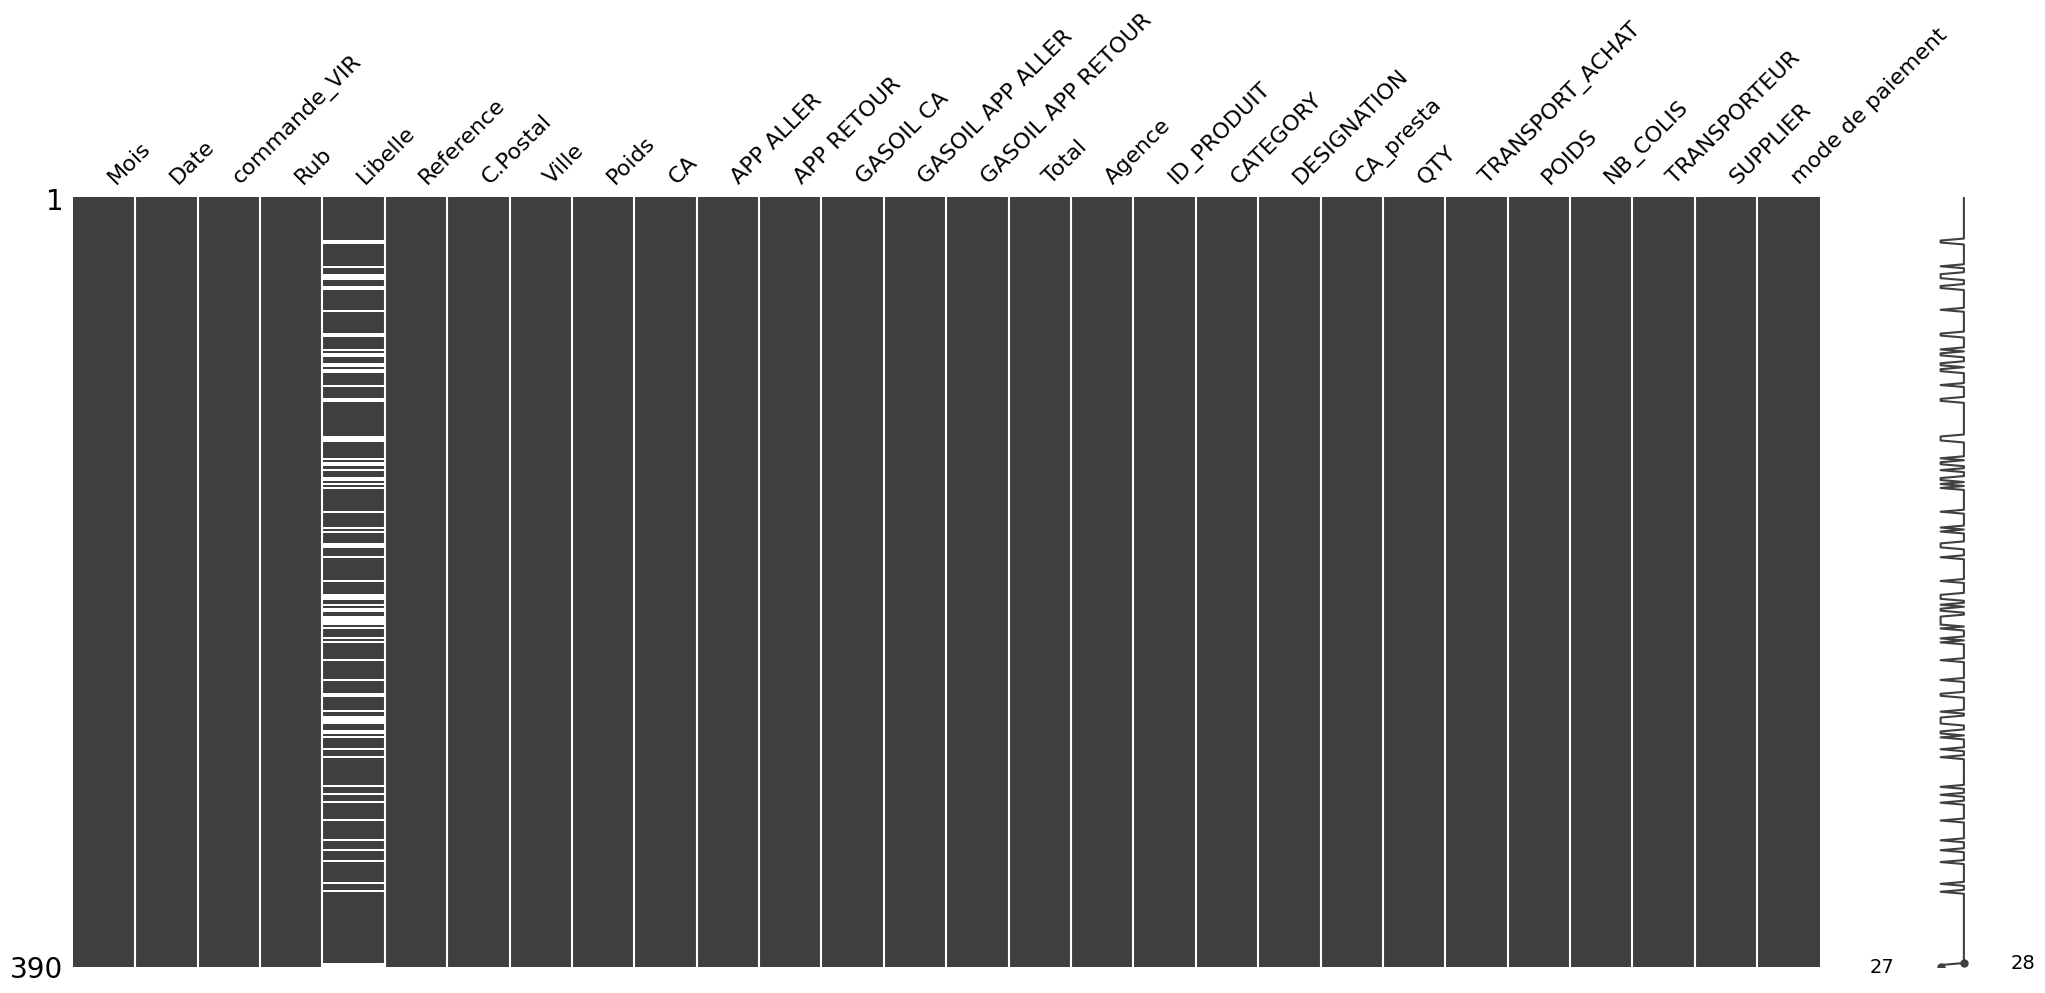

In [ ]:
msn.matrix(facture_complementaire_merged)

In [ ]:
# Colonnes des deux DataFrames
columns_prinipale = set(facture_principale_merged.columns)
columns_complementaire = set(facture_complementaire_merged.columns)

# Colonnes identiques
identical_columns = columns_prinipale.intersection(columns_complementaire)

# Colonnes différentes
different_columns_prinipale = columns_prinipale.difference(columns_complementaire)
different_columns_facture_complementaire = columns_complementaire.difference(columns_prinipale)

# Résultats
print("Colonnes identiques :", identical_columns)
print("Colonnes dans df1 mais pas dans df2 :", different_columns_prinipale)
print("Colonnes dans df2 mais pas dans df1 :", different_columns_facture_complementaire )

Colonnes identiques : {'Poids', 'Ville', 'Libelle', 'C.Postal', 'Reference', 'TRANSPORT_ACHAT', 'POIDS', 'QTY', 'DESIGNATION', 'Agence', 'CA_presta', 'Date', 'ID_PRODUIT', 'CATEGORY', 'TRANSPORTEUR', 'mode de paiement', 'Total', 'commande_VIR', 'CA', 'Mois', 'NB_COLIS', 'Rub', 'SUPPLIER'}
Colonnes dans df1 mais pas dans df2 : {'APPROCHE', 'saisie', 'GASOIL APP', 'Dir', 'Volume', 'Code', 'DISTRIBUTION', 'GASOIL DISTRI'}
Colonnes dans df2 mais pas dans df1 : {'APP RETOUR', 'GASOIL APP ALLER', 'APP ALLER', 'GASOIL APP RETOUR', 'GASOIL CA'}


In [ ]:
facture_complementaire_merged.columns

Index(['Mois', 'Date', 'commande_VIR', 'Rub', 'Libelle', 'Reference',
       'C.Postal', 'Ville', 'Poids', 'CA', 'APP ALLER', 'APP RETOUR',
       'GASOIL CA', 'GASOIL APP ALLER', 'GASOIL APP RETOUR', 'Total', 'Agence',
       'ID_PRODUIT', 'CATEGORY', 'DESIGNATION', 'CA_presta', 'QTY',
       'TRANSPORT_ACHAT', 'POIDS', 'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER',
       'mode de paiement'],
      dtype='object')

In [ ]:
# Step 1: Create or update the monthly file with Complementaire_1 sheet
if os.path.exists(monthly_file_path):
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='a') as writer:
        if 'Complementaire_1' not in writer.book.sheetnames:
            facture_complementaire_merged.to_excel(writer, sheet_name='Complementaire_1', index=False)
else:
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='w') as writer:
        facture_complementaire_merged.to_excel(writer, sheet_name='Complementaire_1', index=False)

print("Monthly data for Complementaire_1 has been saved.")


Monthly data for Complementaire_1 has been saved.


In [ ]:
# Step 1: Check if the annual file exists
if not os.path.exists(annual_file_path):
    # Create a new Excel file with the 'Complementaire_1' sheet
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='w') as writer:
        facture_complementaire_merged.to_excel(writer, sheet_name='Complementaire_1', index=False)
    print(f"Annual file created at: {annual_file_path}")

else:
    # If the file exists, read the existing data from the 'Complementaire_1' sheet
    try:
        existing_annual_data = pd.read_excel(annual_file_path, sheet_name='Complementaire_1')
        # Concatenate the existing data with the new data
        updated_annual_data = pd.concat([existing_annual_data, facture_complementaire_merged], ignore_index=True)

    except ValueError as e:
        # Handle case where the 'Complementaire_1' sheet does not exist
        if 'Worksheet named' in str(e):
            print("Worksheet 'Complementaire_1' not found. Creating a new one.")
            updated_annual_data = facture_complementaire_merged
        else:
            raise  # Raise any other exceptions

    # Save the updated data back to the annual file
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        updated_annual_data.to_excel(writer, sheet_name='Complementaire_1', index=False)

    print("Annual data for Complementaire_1 has been updated.")

Annual data for Complementaire_1 has been updated.


## Transactions complementaires dans le fichier facture principale

In [ ]:
facture_complementaire_switch = facture_principale_merged[~filtre_libelle]
facture_complementaire_switch.shape

(483, 31)

In [ ]:
facture_complementaire_switch.columns

Index(['Code', 'commande_VIR', 'Reference', 'C.Postal', 'Ville', 'Date', 'Rub',
       'Libelle', 'CA', 'DISTRIBUTION', 'APPROCHE', 'GASOIL DISTRI',
       'GASOIL APP', 'Agence', 'Dir', 'Volume', 'Poids', 'saisie',
       'ID_PRODUIT', 'CATEGORY', 'DESIGNATION', 'CA_presta', 'QTY',
       'TRANSPORT_ACHAT', 'POIDS', 'NB_COLIS', 'TRANSPORTEUR', 'SUPPLIER',
       'mode de paiement', 'Total', 'Mois'],
      dtype='object')

In [ ]:
facture_complementaire_switch = facture_complementaire_switch[colonnes_ordre]

In [ ]:
facture_complementaire_switch['Libelle'].value_counts()

,count
Libelle,
REPRISE POUR DESTRUCTION CANAPE,294
FRAIS ADMINISTRATIFS,107
MONTAGE CLASSE B,22
PASSAGE A 4,20
ENLEVEMENT DEPOT,11
REPRISE POUR DESTRUCTION MEUBLE,10
MONTAGE CLASSE A,7
RETOUCHE TEL,3
STOCKAGE,2


In [ ]:
# Step 1: Create or update the monthly file with Complementaire_2 sheet
if os.path.exists(monthly_file_path):
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='a') as writer:
        if 'Complementaire_2' not in writer.book.sheetnames:
            facture_complementaire_switch.to_excel(writer, sheet_name='Complementaire_2', index=False)
else:
    with pd.ExcelWriter(monthly_file_path, engine='openpyxl', mode='w') as writer:
        facture_complementaire_switch.to_excel(writer, sheet_name='Complementaire_2', index=False)

print("Monthly data for Complementaire_2 has been saved.")


Monthly data for Complementaire_2 has been saved.


In [ ]:
# Step 1: Check if the annual file exists
if not os.path.exists(annual_file_path):
    # Create a new Excel file with the 'Complementaire_2' sheet
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='w') as writer:
        facture_complementaire_switch.to_excel(writer, sheet_name='Complementaire_2', index=False)
    print(f"Annual file created at: {annual_file_path}")

else:
    # If the file exists, read the existing data from the 'Complementaire_2' sheet
    try:
        existing_annual_data = pd.read_excel(annual_file_path, sheet_name='Complementaire_2')
        # Concatenate the existing data with the new data
        updated_annual_data = pd.concat([existing_annual_data,facture_complementaire_switch], ignore_index=True)

    except ValueError as e:
        # Handle case where the 'Complementaire_2' sheet does not exist
        if 'Worksheet named' in str(e):
            print("Worksheet 'Complementaire_2' not found. Creating a new one.")
            updated_annual_data = facture_complementaire_switch
        else:
            raise  # Raise any other exceptions

    # Save the updated data back to the annual file
    with pd.ExcelWriter(annual_file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        updated_annual_data.to_excel(writer, sheet_name='Complementaire_2', index=False)

    print("Annual data for Complementaire_2 has been updated.")

Annual data for Complementaire_2 has been updated.
